# Sequence To SQL

Welcome to our project in the Advanced Natural Language Processing course

We try to build it with the data provided in https://github.com/salesforce/WikiSQL

Remove this: https://towardsdatascience.com/text-to-sql-learning-to-query-tables-with-natural-language-7d714e60a70d?gi=6b6c7e91e298

In [1]:
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm, trange
from torch import nn

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print('Current device:', torch.cuda.get_device_name(device))
else:
    print('Failed to find GPU. Will use CPU.')
    device = 'cpu'

Failed to find GPU. Will use CPU.


# Data collection and Review
Clone the data from the WikiSQL git repository and install them.

Take a look inside the data

In [3]:
import json

def read_json_data_from_file(file: str):
  ret_data = []
  with open(file) as json_file:
      # Get next line from file
      lines = json_file.readlines()
      for line in tqdm(lines):
          if not line:
            break

          data = json.loads(line)
          ret_data.append(data)
  return ret_data

def convert_to_id_dict(data, id_key: str):
  ret_dict = {}
  for element in data:
    if id_key in element:
      ret_dict[element[id_key]] = element
    else:
      print(f'Element {element} doenst contain key {id_key}')
  return ret_dict

Lets see if we succesfully serialized the data into objects.

In [4]:
data_folder = "../data"

dev_req_data = read_json_data_from_file(f'{data_folder}/dev.jsonl')
dev_table_data = read_json_data_from_file(f'{data_folder}/dev.tables.jsonl')

print(f'We have {len(dev_req_data)} dev data with {len(dev_table_data)} tables.')
print(f'An example Request: ')
print(json.dumps(dev_req_data[0], indent=2))

  0%|          | 0/8421 [00:00<?, ?it/s]

  0%|          | 0/2716 [00:00<?, ?it/s]

We have 8421 dev data with 2716 tables.
An example Request: 
{
  "phase": 1,
  "table_id": "1-10015132-11",
  "question": "What position does the player who played for butler cc (ks) play?",
  "sql": {
    "sel": 3,
    "conds": [
      [
        5,
        0,
        "Butler CC (KS)"
      ]
    ],
    "agg": 0
  }
}


### The fields represent the following:

* `phase`: the phase in which the dataset was collected. We collected WikiSQL in two phases.
* `question`: the natural language question written by the worker.
* `table_id`: the ID of the table to which this question is addressed.
sql: the SQL query corresponding to the question. This has the following *subfields:
  * `sel`: the numerical index of the column that is being selected. You can find the actual column from the table.
  * `agg`: the numerical index of the aggregation operator that is being used. You can find the actual operator from Query.agg_ops in lib/query.py.
  * `conds`: a list of triplets (column_index, operator_index, condition) where:
    * `column_index`: the numerical index of the condition column that is being used. You can find the actual column from the table.
    * `operator_index`: the numerical index of the condition operator that is being used. You can find the actual operator from Query.cond_ops in lib/query.py.
    * `condition`: the comparison value for the condition, in either string or float type.


## An example Table

In [5]:
print(json.dumps(dev_table_data[0], indent=2))

{
  "header": [
    "Player",
    "No.",
    "Nationality",
    "Position",
    "Years in Toronto",
    "School/Club Team"
  ],
  "page_title": "Toronto Raptors all-time roster",
  "types": [
    "text",
    "text",
    "text",
    "text",
    "text",
    "text"
  ],
  "id": "1-10015132-11",
  "section_title": "L",
  "caption": "L",
  "rows": [
    [
      "Antonio Lang",
      "21",
      "United States",
      "Guard-Forward",
      "1999-2000",
      "Duke"
    ],
    [
      "Voshon Lenard",
      "2",
      "United States",
      "Guard",
      "2002-03",
      "Minnesota"
    ],
    [
      "Martin Lewis",
      "32, 44",
      "United States",
      "Guard-Forward",
      "1996-97",
      "Butler CC (KS)"
    ],
    [
      "Brad Lohaus",
      "33",
      "United States",
      "Forward-Center",
      "1996",
      "Iowa"
    ],
    [
      "Art Long",
      "42",
      "United States",
      "Forward-Center",
      "2002-03",
      "Cincinnati"
    ],
    [
      "John Long",


Amount of max columns: 20


Text(0.5, 6.79999999999999, 'Token count')

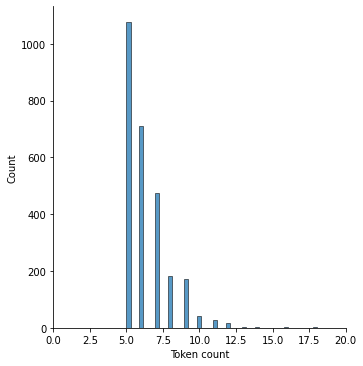

In [6]:
column_amount = []
for table in dev_table_data:
    column_amount.append(len(table['header']))

print(f'Amount of max columns: {np.max(column_amount)}')

sns.displot(column_amount)
plt.xlim([0, 20])
plt.xlabel('Token count')



## Preprocess

The data is stored with indices but we need the actual column names so saturate the requests with the data

In [7]:
# Transform the data into a dictonary index by the id
dev_table_data_dict = convert_to_id_dict(dev_table_data, 'id')

In [8]:
# Get the preliminary data
# Maybe we want the other idexes also

In [9]:
def get_table_column(data_list, tables_dict):
  ret_list = []
  for element in data_list:
    current_table = tables_dict[element['table_id']]
    columns = current_table['header']
    # Replace the index
    element['columns'] = columns
    element['types'] = current_table['types']
    element['sql']['sel_name'] = columns[element['sql']['sel']]

    if 'page_title' in current_table:
        element['table_name'] = current_table['page_title']
    elif 'section_title' in current_table:
        element['table_name'] = current_table['section_title']
    elif 'caption' in current_table:
        element['table_name'] = current_table['caption']
    elif 'name' in current_table:
        element['table_name'] = current_table['name']

    # For the where conditions
    for cond in element['sql']['conds']:
      cond[0] = columns[cond[0]]
    ret_list.append(element)
  return ret_list


In [10]:
dev_req_data = read_json_data_from_file(f'{data_folder}/dev.jsonl')
dev_table_data = read_json_data_from_file(f'{data_folder}/dev.tables.jsonl')

dev_prep_req_data = get_table_column(dev_req_data, dev_table_data_dict)


print(f'Filed in with the Columns: ')
print(json.dumps(dev_prep_req_data[-2], indent=2))


  0%|          | 0/8421 [00:00<?, ?it/s]

  0%|          | 0/2716 [00:00<?, ?it/s]

Filed in with the Columns: 
{
  "phase": 2,
  "table_id": "2-12601141-1",
  "question": "Which state does Jimmy Quillen represent?",
  "sql": {
    "sel": 2,
    "conds": [
      [
        "Representative",
        0,
        "jimmy quillen"
      ]
    ],
    "agg": 0,
    "sel_name": "State"
  },
  "columns": [
    "Representative",
    "Years",
    "State",
    "Party",
    "Lifespan"
  ],
  "types": [
    "text",
    "text",
    "text",
    "text",
    "text"
  ],
  "table_name": "List of former members of the United States House of Representatives (Q)"
}


In [11]:
# TODO figure out a good padding size or how to do padding correctly

def get_question_answers(request, tokenizer):
    input_list = []

    table_name = request['table_name'] #should be name not id
    space_token = ' '
    columns = request['columns']
    req_question = request['question'] # might need to be tokenized
    max_len = 0
    for i, col in enumerate(columns):
        col_type = request['types'][i] # infere type somehow
        column_representation = col_type + space_token + table_name + space_token + col
        embedding = tokenizer.encode_plus(
            column_representation,
            req_question,
            add_special_tokens=True,
        )
        if max_len < len(embedding['input_ids']):
            max_len = len(embedding['input_ids'])

    for i, col in enumerate(columns):
        col_type = request['types'][i] # infere type somehow
        column_representation = col_type + space_token + table_name + space_token + col
        embedding = tokenizer.encode_plus(
            column_representation,
            req_question,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_overflowing_tokens=True,
            return_attention_mask=True,
        )
        input_list.append(embedding)
    return input_list

In [12]:
def get_question_answers_def_length(request, tokenizer, pad_max_length):
    input_list = []

    table_name = request['table_name'] #should be name not id
    space_token = ' '
    columns = request['columns']
    req_question = request['question'] # might need to be tokenized
    for i, col in enumerate(columns):
        col_type = request['types'][i] # infere type somehow
        column_representation = col_type + space_token + table_name + space_token + col
        embedding = tokenizer.encode_plus(
            column_representation,
            req_question,
            add_special_tokens=True,
            max_length=pad_max_length,
            padding='max_length',
            truncation = True,
            return_overflowing_tokens=True,
            return_attention_mask=True,
        )
        input_list.append(embedding)
    return input_list

def get_question_answers_for_where_value_def_length(request, tokenizer, pad_max_length):
    input_list = []
    target_list = []
    cond_dict = {0:"equal to ", 1:"less than ", 2:"more than ", 3:"OP "}

    #agg_ops = ['', 'MAX', 'MIN', 'COUNT', 'SUM', 'AVG']
    #cond_ops = ['=', '>', '<', 'OP']

    space_token = ' '
    req_question = request['question'] # might need to be tokenized

    conditions = request['sql']['conds']
    for i, cond in enumerate(conditions):
        column_name = cond[0]
        opp_name = cond_dict[cond[1]]
        target = cond[2]
        value_question = column_name + space_token + opp_name
        #print(f"target:{target}")
        #print(f"question: {req_question}")
        embedding = tokenizer.encode_plus(
            text=value_question,
            text_pair=req_question,
            add_special_tokens=True,
            max_length=pad_max_length,
            padding='max_length',
            truncation = True,
            return_overflowing_tokens=True,
            return_attention_mask=True,
        )
        #print(f"embedding:{embedding}")

        input_list.append(embedding)
        encoded_target = tokenizer.encode(text=str(target),add_special_tokens=True)[1:-1]
        startIdx = 0
        endIdx = 0
        #print(f"target:{target}")
        #print(f"target_emb:{encoded_target}")
        sll=len(encoded_target)
        for ind in (i for i,e in enumerate(embedding['input_ids']) if e == encoded_target[0]):
            if embedding['input_ids'][ind:ind+sll]==encoded_target:
                startIdx = ind
                endIdx = ind+sll
                break
        #this is nessecary for some targets are uppercase while in the questions they are lowercase
        if startIdx==0 and endIdx==0:
            encoded_target = tokenizer.encode(text=str(target).lower(),add_special_tokens=True)[1:-1]
            sll=len(encoded_target)
            for ind in (i for i,e in enumerate(embedding['input_ids']) if e == encoded_target[0]):
                if embedding['input_ids'][ind:ind+sll]==encoded_target:
                    startIdx = ind
                    endIdx = ind+sll
                    break

        #print(f"start:{startIdx}, endidx: {endIdx}")
        target_list.append([startIdx,endIdx])

    return input_list, target_list


In [13]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

token_amount = []
for req in tqdm(dev_prep_req_data):
    column_question_pairs = get_question_answers(req, tokenizer)
    for column_question_pair in column_question_pairs:
        token_amount.append(len(column_question_pair['input_ids']))

print(f'Amount of max tockens: {np.max(token_amount)}')

  0%|          | 0/8421 [00:00<?, ?it/s]

Amount of max tockens: 107


Text(0.5, 6.79999999999999, 'Token count')

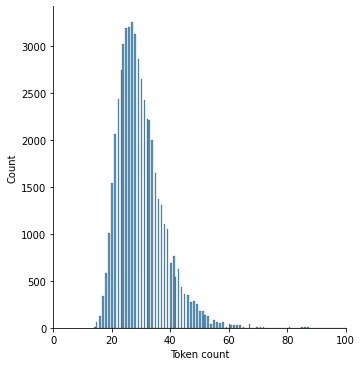

In [14]:
sns.displot(token_amount)
plt.xlim([0, 100])
plt.xlabel('Token count')


# Create data loader that transformed the stuff

In [15]:
from enum import Enum
class Task(Enum):
    SELECT = 1

In [16]:
import numpy as np
from torch.utils.data import Dataset, DataLoader

class WikiSQLDataset(Dataset):

    def __init__(self, requests, tokenizer, pad_length):
        self.requests = requests
        self.tokenizer = tokenizer
        self.pad_length = pad_length

        self.req_prepared = []
        self.full_requests = []

        self.QA_requests = []

        for req in requests:
            _qa_values, _qa_targets = get_question_answers_for_where_value_def_length(req, self.tokenizer, self.pad_length)
            _qa_input_ids = [req_embedding['input_ids'] for req_embedding in _qa_values]
            _qa_token_type_ids = [req_embedding['token_type_ids'] for req_embedding in _qa_values]
            _qa_attention_mask = [req_embedding['attention_mask'] for req_embedding in _qa_values]

            _qa_where_value = torch.tensor(_qa_targets)

            _req_embeddings = get_question_answers_def_length(req, self.tokenizer, self.pad_length)
            _input_ids = [req_embedding['input_ids'] for req_embedding in _req_embeddings]
            _token_type_ids = [req_embedding['token_type_ids'] for req_embedding in _req_embeddings]
            _attention_mask = [req_embedding['attention_mask'] for req_embedding in _req_embeddings]

            #correct_sel_id = np.zeros((len(req['columns']),1), dtype=int)
            #correct_sel_id[req['sql']['sel']][0] = 1

            correct_sel_id = np.array([req['sql']['sel']], dtype=int)

            #num_agg = 6
            #correct_agg_id =  np.zeros((num_agg,1), dtype=int)
            #correct_agg_id[req['sql']['agg']][0] = 1

            correct_agg_id = np.array([req['sql']['agg']], dtype=int)

            #correct_where_conditions = []
            # conds = [[colName, OpperationID, value],[colName, OpperationID, value]]


            select_target = torch.tensor([correct_sel_id], dtype=torch.long)
            select_agg_target = torch.tensor([correct_agg_id], dtype=torch.long)


            self.req_prepared.append(dict(
                input_ids = torch.tensor(_input_ids),
                token_type_ids = torch.tensor(_token_type_ids),
                attention_mask = torch.tensor(_attention_mask),

                qa_input_ids = torch.tensor(_qa_input_ids),
                qa_attention_mask = torch.tensor(_qa_attention_mask),
                qa_token_type_ids = torch.tensor(_qa_token_type_ids),

                target = dict(
                    SELECT = select_target,
                    SELECT_AGG = select_agg_target,
                    WHERE_VALUE =  torch.tensor(_qa_targets)
                )
            ))
            self.full_requests.append(req)




    def get_full_request_by_id(self, req_id):
        return self.full_requests[req_id]

    def __len__(self):
        return len(self.req_prepared)

    def __getitem__(self, item):
        return self.req_prepared[item]

def get_data_loader(data_type, tokenizer, batch_size, filter_data = True, pad_length = 65):
    # TODO check if we can use DataLoader with batch size as done in the tutorial
    loaded_req = read_json_data_from_file(f'{data_folder}/{data_type}.jsonl')
    loaded_tables = read_json_data_from_file(f'{data_folder}/{data_type}.tables.jsonl')
    table_data_dict = convert_to_id_dict(loaded_tables, 'id')

    prep_req_data = get_table_column(loaded_req, table_data_dict)

    if filter_data:
        prep_req_data = list(filter(lambda request: len(request['columns']) == 5, prep_req_data))

    print(f'We have {len(loaded_req)} {data_type} data with {len(loaded_tables)} tables.')

    return DataLoader(
        WikiSQLDataset(requests = prep_req_data, tokenizer = tokenizer, pad_length = pad_length),
        batch_size=batch_size
    )

from transformers import BertTokenizer

data_folder = '../data'

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
train_data_loader = get_data_loader(data_type='dev', tokenizer = tokenizer, batch_size = 16)

  0%|          | 0/8421 [00:00<?, ?it/s]

  0%|          | 0/2716 [00:00<?, ?it/s]

We have 8421 dev data with 2716 tables.


In [17]:
for d in train_data_loader:
    try:
        #d = next(iterator)
        if d["input_ids"].shape[2] != 65 or d["input_ids"].shape[1] != 5:
            print(f'input_ids: {d["input_ids"].shape}')
        if d["attention_mask"].shape[2] != 65 or d["attention_mask"].shape[1] != 5:
            print(f'attention_mask: {d["attention_mask"].shape}')
        if d["token_type_ids"].shape[2] != 65 or d["token_type_ids"].shape[1] != 5:
            print(f'token_type_ids: {d["token_type_ids"].shape}')
        # print(f'target: {d["target"]["SELECT"].shape}')
    except:
        print(d)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'target'])


{'input_ids': tensor([[[ 101, 3087, 5619,  ...,    0,    0,    0],
          [ 101, 3087, 5619,  ...,    0,    0,    0],
          [ 101, 3087, 5619,  ...,    0,    0,    0],
          [ 101, 3087, 5619,  ...,    0,    0,    0],
          [ 101, 3087, 5619,  ...,    0,    0,    0]],
 
         [[ 101, 3087, 5619,  ...,    0,    0,    0],
          [ 101, 3087, 5619,  ...,    0,    0,    0],
          [ 101, 3087, 5619,  ...,    0,    0,    0],
          [ 101, 3087, 5619,  ...,    0,    0,    0],
          [ 101, 3087, 5619,  ...,    0,    0,    0]],
 
         [[ 101, 3087, 1952,  ...,    0,    0,    0],
          [ 101, 3087, 1952,  ...,    0,    0,    0],
          [ 101, 3087, 1952,  ...,    0,    0,    0],
          [ 101, 3087, 1952,  ...,    0,    0,    0],
          [ 101, 3087, 1952,  ...,    0,    0,    0]],
 
         ...,
 
         [[ 101, 3087, 1952,  ...,    0,    0,    0],
          [ 101, 1842, 1952,  ...,    0,    0,    0],
          [ 101, 3087, 1952,  ...,    0,    

# Test question answer to Build the model

In this section, we will look into **contextual embeddings**.

For this we use [**pretrained BERT**](https://www.aclweb.org/anthology/N19-1423.pdf) provided via [HuggingFace](https://huggingface.co/).

Let's first install the HuggingFace python package:

In [ ]:
# reference is hydranet https://arxiv.org/pdf/2008.04759.pdf
# Dp imports here
from transformers import BertTokenizer, BertModel

# Generall model configuration
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
sep_token = tokenizer.sep_token
cls_token = tokenizer.cls_token

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [19]:
print(dev_prep_req_data[0])
for tokens in get_question_answers(dev_prep_req_data[0], tokenizer):
    print(tokens)
    print(tokenizer.convert_ids_to_tokens(tokens['input_ids']))

In [20]:
req_embeddings = get_question_answers(dev_prep_req_data[-2], tokenizer)
print(req_embeddings)
input_ids = [req_embedding['input_ids'] for req_embedding in req_embeddings]
token_type_ids = [req_embedding['token_type_ids'] for req_embedding in req_embeddings]
attention_mask = [req_embedding['attention_mask'] for req_embedding in req_embeddings]

{'phase': 1, 'table_id': '1-10015132-11', 'question': 'What position does the player who played for butler cc (ks) play?', 'sql': {'sel': 3, 'conds': [['School/Club Team', 0, 'Butler CC (KS)']], 'agg': 0, 'sel_name': 'Position'}, 'columns': ['Player', 'No.', 'Nationality', 'Position', 'Years in Toronto', 'School/Club Team'], 'types': ['text', 'text', 'text', 'text', 'text', 'text'], 'table_name': 'Toronto Raptors all-time roster'}
{'overflowing_tokens': [], 'num_truncated_tokens': -3, 'input_ids': [101, 3087, 3506, 21196, 5067, 1155, 118, 1159, 9197, 5348, 102, 1327, 1700, 1674, 1103, 1591, 1150, 1307, 1111, 23635, 14402, 113, 180, 1116, 114, 1505, 136, 102, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]}
['[CLS]', 'text', 'Toronto', 'Rap', '##tors', 'all', '-', 'time', 'roster', 'Player', '[SEP]', 'W

In [21]:
print(input_ids)
print(token_type_ids)
print(attention_mask)

[{'overflowing_tokens': [], 'num_truncated_tokens': -1, 'input_ids': [101, 3087, 5619, 1104, 1393, 1484, 1104, 1103, 1244, 1311, 1585, 1104, 5423, 113, 154, 114, 7725, 102, 5979, 1352, 1674, 4479, 154, 16966, 7836, 4248, 136, 102, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]}, {'overflowing_tokens': [], 'num_truncated_tokens': -1, 'input_ids': [101, 3087, 5619, 1104, 1393, 1484, 1104, 1103, 1244, 1311, 1585, 1104, 5423, 113, 154, 114, 5848, 102, 5979, 1352, 1674, 4479, 154, 16966, 7836, 4248, 136, 102, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]}, {'overflowing_tokens': [], 'num_truncated_tokens': -1, 'input_ids': [101, 3087, 5619, 1104, 1393, 148

In [22]:
input_ids_tensor = torch.tensor(input_ids)
token_type_ids_tensor = torch.tensor(token_type_ids)
attention_mask_tensor = torch.tensor(attention_mask)

print(input_ids_tensor.shape)
print(token_type_ids_tensor.shape)
print(attention_mask_tensor.shape)

outputs = model(
    input_ids=input_ids_tensor, # The tokens representing our input text.
    attention_mask=token_type_ids_tensor,
    token_type_ids=attention_mask_tensor
) # The segment IDs to differentiate question from answer_text
outputs

[[101, 3087, 5619, 1104, 1393, 1484, 1104, 1103, 1244, 1311, 1585, 1104, 5423, 113, 154, 114, 7725, 102, 5979, 1352, 1674, 4479, 154, 16966, 7836, 4248, 136, 102, 0], [101, 3087, 5619, 1104, 1393, 1484, 1104, 1103, 1244, 1311, 1585, 1104, 5423, 113, 154, 114, 5848, 102, 5979, 1352, 1674, 4479, 154, 16966, 7836, 4248, 136, 102, 0], [101, 3087, 5619, 1104, 1393, 1484, 1104, 1103, 1244, 1311, 1585, 1104, 5423, 113, 154, 114, 1426, 102, 5979, 1352, 1674, 4479, 154, 16966, 7836, 4248, 136, 102, 0], [101, 3087, 5619, 1104, 1393, 1484, 1104, 1103, 1244, 1311, 1585, 1104, 5423, 113, 154, 114, 1786, 102, 5979, 1352, 1674, 4479, 154, 16966, 7836, 4248, 136, 102, 0], [101, 3087, 5619, 1104, 1393, 1484, 1104, 1103, 1244, 1311, 1585, 1104, 5423, 113, 154, 114, 2583, 27894, 102, 5979, 1352, 1674, 4479, 154, 16966, 7836, 4248, 136, 102]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,

In [23]:
print(f'last hidden state  : {outputs.last_hidden_state.shape}')
print(f'pooled output layer: {outputs.pooler_output.shape}')

torch.Size([5, 29])
torch.Size([5, 29])
torch.Size([5, 29])


BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.3507, -0.0581, -0.2104,  ...,  0.1988,  0.0743,  0.1084],
         [ 0.2660, -0.3266, -0.4412,  ...,  0.4873,  0.4901,  0.0832],
         [-0.0448, -0.3415, -0.4355,  ...,  0.2672,  0.3468,  0.0902],
         ...,
         [ 0.3708, -0.3513, -0.5675,  ...,  0.4988, -0.0255,  0.0643],
         [ 0.1847, -0.2189, -0.6240,  ...,  0.8887,  0.7120,  0.1169],
         [ 0.6433, -0.4236,  0.0704,  ..., -0.1497,  0.4813,  0.0973]],

        [[ 0.3507, -0.0581, -0.2104,  ...,  0.1988,  0.0743,  0.1084],
         [ 0.2660, -0.3266, -0.4412,  ...,  0.4873,  0.4901,  0.0832],
         [-0.0448, -0.3415, -0.4355,  ...,  0.2672,  0.3468,  0.0902],
         ...,
         [ 0.3708, -0.3513, -0.5675,  ...,  0.4988, -0.0255,  0.0643],
         [ 0.1847, -0.2189, -0.6240,  ...,  0.8887,  0.7120,  0.1169],
         [ 0.6433, -0.4236,  0.0704,  ..., -0.1497,  0.4813,  0.0973]],

        [[ 0.3507, -0.0581, -0.2104,  ...,  0.1988,  

In [24]:
from torch import nn
import torch.nn.functional as F

# weight = torch.rand(model.config.hidden_size)
# F.sigmoid(F.linear(outputs.pooler_output, weight))

out = nn.Linear(model.config.hidden_size, 1)
out2 = torch.softmax(torch.sigmoid(out(outputs.pooler_output)), dim = 0)

torch.argmax(out2)

last hidden state  : torch.Size([5, 29, 768])
pooled output layer: torch.Size([5, 768])


# Define the model

In [ ]:
class BertBaseModel(nn.Module):
    def __init__(self):
        super(BertBaseModel, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(
            input_ids=input_ids.squeeze(0),
            attention_mask=attention_mask.squeeze(0),
            token_type_ids=token_type_ids.squeeze(0)
        )
        return outputs

class SelectionRanker(nn.Module):
    def __init__(self, bert_model):
        super(SelectionRanker, self).__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.linear = nn.Linear(self.bert.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):

        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        output = self.drop(outputs.pooler_output)
        linear = self.linear(output)
        softmax = torch.softmax(torch.sigmoid(linear), dim = 0)
        return torch.transpose(softmax, 0, 1)

# Train

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    with tqdm(data_loader, unit="batch") as tepoch:
        for d in tepoch:
            # req = d["request"]
            input_id_batch = d["input_ids"].to(device)# [_input_ids.to(device) for _input_ids in d["input_ids"]]
            attention_mask_batch = d["attention_mask"].to(device) # [_attention_mask.to(device) for _attention_mask in d["attention_mask"]]
            token_type_ids_batch = d["token_type_ids"].to(device) # [_token_type_ids.to(device) for _token_type_ids in d["token_type_ids"]]
            targets_batsch = d["target"]['SELECT'].to(device)

            for batchIdx in range(len(input_id_batch)):
                input_ids = input_id_batch[batchIdx]# [_input_ids.to(device) for _input_ids in d["input_ids"]]
                attention_mask = attention_mask_batch[batchIdx] # [_attention_mask.to(device) for _attention_mask in d["attention_mask"]]
                token_type_ids = token_type_ids_batch[batchIdx] # [_token_type_ids.to(device) for _token_type_ids in d["token_type_ids"]]
                targets = targets_batsch[batchIdx][0]

                #print(f"input_ids.shape:{input_ids.shape}")
                #print(f"attention_mask.shape:{attention_mask.shape}")
                #print(f"token_type_ids .shape:{token_type_ids .shape}")

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids= token_type_ids,
                )
                pred_req_id = torch.argmax(outputs, dim=1)

                #print(f"output.shape:{outputs}")
                #print(f"pred_req_id.shape:{pred_req_id}")
                #print(f"target.shape:{targets.shape}")

                loss = loss_fn(outputs, targets)
                correct_predictions += 1 if pred_req_id == targets else 0
                losses.append(loss.item())
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

                tepoch.set_postfix(loss=loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        with tqdm(data_loader, unit="batch") as tepoch:
            for d in tepoch:
                # req = d["request"]
                input_id_batch = d["input_ids"].to(device)# [_input_ids.to(device) for _input_ids in d["input_ids"]]
                attention_mask_batch = d["attention_mask"].to(device) # [_attention_mask.to(device) for _attention_mask in d["attention_mask"]]
                token_type_ids_batch = d["token_type_ids"].to(device) # [_token_type_ids.to(device) for _token_type_ids in d["token_type_ids"]]
                targets_batsch = d["target"]['SELECT'].to(device)

                for batchIdx in range(len(input_id_batch)):
                    input_ids = input_id_batch[batchIdx]# [_input_ids.to(device) for _input_ids in d["input_ids"]]
                    attention_mask = attention_mask_batch[batchIdx] # [_attention_mask.to(device) for _attention_mask in d["attention_mask"]]
                    token_type_ids = token_type_ids_batch[batchIdx] # [_token_type_ids.to(device) for _token_type_ids in d["token_type_ids"]]
                    targets = targets_batsch[batchIdx][0]

                    #print(f"input_ids.shape:{input_ids.shape}")
                    #print(f"attention_mask.shape:{attention_mask.shape}")
                    #print(f"token_type_ids .shape:{token_type_ids .shape}")

                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids= token_type_ids,
                    )
                    pred_req_id = torch.argmax(outputs, dim=1)

                    #print(f"output.shape:{outputs}")
                    #print(f"pred_req_id.shape:{pred_req_id}")
                    #print(f"target.shape:{targets.shape}")

                    loss = loss_fn(outputs, targets)
                    correct_predictions += 1 if pred_req_id == targets else 0
                    losses.append(loss.item())

                    tepoch.set_postfix(loss=loss.item())


        return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup


EPOCHS = 3
history = defaultdict(list)
best_accuracy = 0

bert_model = BertBaseModel()
selection_ranker = SelectionRanker(bert_model)
selection_ranker = selection_ranker.to(device)


optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(dev_prep_req_data) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.NLLLoss().to(device)

train_data_loader = get_data_loader(data_type='train', tokenizer = tokenizer, batch_size = 16)
val_data_loader = get_data_loader(data_type='dev', tokenizer = tokenizer, batch_size = 16)
# test_data_loader = get_data_loader('train', tokenizer)

In [28]:
print("started training!")
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    selection_ranker,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_data_loader)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    selection_ranker,
    val_data_loader,
    loss_fn,
    device,
    len(val_data_loader)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc


  0%|          | 0/56355 [00:00<?, ?it/s]

  0%|          | 0/18585 [00:00<?, ?it/s]

We have 56355 train data with 18585 tables.


KeyboardInterrupt: 

In [ ]:
test_data_loader = get_data_loader(data_type='dev', tokenizer = tokenizer, batch_size = 16)

In [29]:
class BertBaseModelBatches(nn.Module):
    def __init__(self, config=None):
        super(BertBaseModelBatches, self).__init__()
        if config:
            self.bert_model = BertModel.from_pretrained('bert-base-uncased', config=config)
        else:
            self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(
            input_ids=input_ids.flatten(end_dim=1),
            attention_mask=attention_mask.flatten(end_dim=1),
            token_type_ids=token_type_ids.flatten(end_dim=1)
        )
        return outputs

class SelectionRankerBatches(nn.Module):
    def __init__(self, bert_model):
        super(SelectionRankerBatches, self).__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.linear = nn.Linear(self.bert.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):

        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        output = self.drop(outputs.pooler_output)
        linear = self.linear(output.view(16, 5, 768))
        softmax = torch.softmax(
            torch.sigmoid(linear),
            dim = 1
        )
        return softmax

bert_model = BertBaseModelBatches()
selection_ranker = SelectionRankerBatches(bert_model)

d = next(iter(test_data_loader))
input_ids = d["input_ids"].to(device)# [_input_ids.to(device) for _input_ids in d["input_ids"]]
attention_mask = d["attention_mask"].to(device) # [_attention_mask.to(device) for _attention_mask in d["attention_mask"]]
token_type_ids = d["token_type_ids"].to(device) # [_token_type_ids.to(device) for _token_type_ids in d["token_type_ids"]]
targets = d["target"]["SELECT"].to(device)

print(input_ids.shape)
print(attention_mask.shape)
print(token_type_ids.shape)

# input_ids.flatten(end_dim=1).view(16,5,65).shape

outputs = selection_ranker(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids= token_type_ids,
)

loss_fn = nn.NLLLoss().to(device)

print(outputs.shape, outputs.squeeze(1).shape)
print(targets.shape, targets.squeeze(1).shape)

print(outputs.shape, outputs.squeeze(1))
print(targets.shape, targets.squeeze(1))
# I dont get why targets is shape [1, 1] and not [1] it is initilized the same way in the data loader

# target = torch.tensor([2], dtype=torch.long).to(device)
# print(target.shape, target)


loss = loss_fn(outputs, targets.squeeze(1))
print(loss)

correct_prediction = torch.sum(torch.argmax(outputs, dim=1) == targets.squeeze(1))
print(f'Number of correct predictions {correct_prediction}')

  0%|          | 0/8421 [00:00<?, ?it/s]

  0%|          | 0/2716 [00:00<?, ?it/s]

We have 8421 dev data with 2716 tables.


In [32]:
class QABert(nn.Module):
    def __init__(self, bert_model, output_num_words):
        super(QABert, self).__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.linearStart = nn.Linear(self.bert.bert.config.hidden_size, output_num_words)
        self.linearEnd= nn.Linear(self.bert.bert.config.hidden_size, output_num_words)

    def forward(self, input_ids, attention_mask, token_type_ids):

        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        startValues = self.linearStart(outputs.last_hidden_state)
        startSoftmax = torch.softmax(startValues, dim=1)

        endValues = self.linearEnd(outputs.last_hidden_state)
        endSoftmax = torch.softmax(endValues, dim=1)

        return startSoftmax, endSoftmax

import torch

if not torch.cuda.is_available():
    device = torch.cuda.current_device()
    print('Current device:', torch.cuda.get_device_name(device))
else:
    print('Failed to find GPU. Will use CPU.')
    device = 'cpu'

d = next(iter(train_data_loader))
input_ids = d["input_ids"][0].to(device)# [_input_ids.to(device) for _input_ids in d["input_ids"]]
attention_mask = d["attention_mask"][0].to(device) # [_attention_mask.to(device) for _attention_mask in d["attention_mask"]]
token_type_ids = d["token_type_ids"][0].to(device) # [_token_type_ids.to(device) for _token_type_ids in d["token_type_ids"]]



#Tokenizer
#tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

#question = '''wage less than '''
#paragraph = '''show please me all employees with a salary smaller than 400 or where the last name is "yannick"'''

#encoding = tokenizer.encode_plus(text=question,text_pair=paragraph, add_special=True)

#inputs = torch.tensor(encoding['input_ids'])  #Token embeddings
#sentence_embedding = torch.tensor(encoding['token_type_ids'])  #Segment embeddings
#attention_mask = torch.tensor(encoding['attention_mask'])


modelWV = QABert(bert_model,1)

print(input_ids.shape)
print(token_type_ids.shape)
print(attention_mask.shape)


output = modelWV(input_ids, attention_mask, token_type_ids)

start_scores = output[0]
print(f"start_scores: {start_scores.shape}")
end_scores = output[1]

start_index = torch.argmax(start_scores, dim=1)

print(f"start_index{start_index}")

end_index = torch.argmax(end_scores, dim=1)

answer = ' '.join(tokens[start_index:end_index+1])
print(answer)
corrected_answer = ''

for word in answer.split():
    #If it's a subword token
    if word[0:2] == '##':
        corrected_answer += word[2:]
    else:
        corrected_answer += ' ' + word
print(corrected_answer)



torch.Size([16, 5, 65])
torch.Size([16, 5, 65])
torch.Size([16, 5, 65])
torch.Size([16, 5, 1]) torch.Size([16, 5, 1])
torch.Size([16, 1, 1]) torch.Size([16, 1])
torch.Size([16, 5, 1]) tensor([[[0.2142],
         [0.1935],
         [0.1999],
         [0.1786],
         [0.2138]],

        [[0.2113],
         [0.1953],
         [0.1886],
         [0.2115],
         [0.1933]],

        [[0.1864],
         [0.1727],
         [0.2169],
         [0.2152],
         [0.2088]],

        [[0.1837],
         [0.1788],
         [0.2003],
         [0.1981],
         [0.2391]],

        [[0.1818],
         [0.1963],
         [0.2190],
         [0.2071],
         [0.1957]],

        [[0.2019],
         [0.2056],
         [0.1922],
         [0.2183],
         [0.1820]],

        [[0.2127],
         [0.1961],
         [0.2118],
         [0.1888],
         [0.1906]],

        [[0.2118],
         [0.2067],
         [0.1867],
         [0.2151],
         [0.1796]],

        [[0.1722],
         [0.1910],
  